## Code for figures

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    FunctionTransformer,
    PowerTransformer,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import make_column_transformer
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

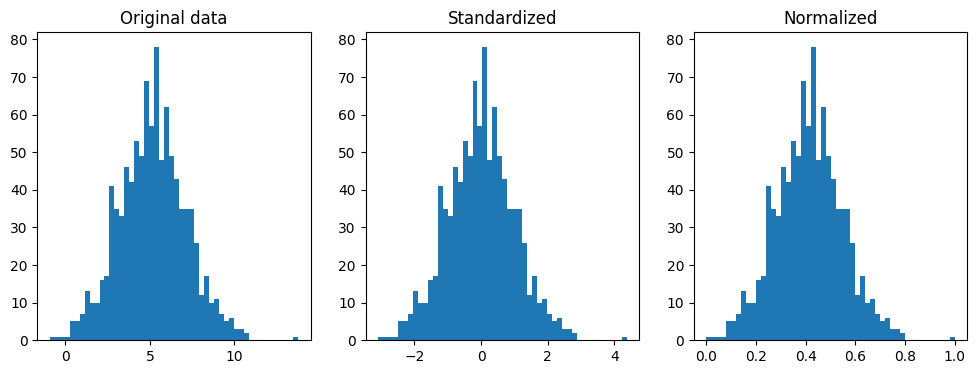

In [3]:
rng = np.random.default_rng(seed=123456)
x = rng.normal(5, 2, 1000)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(x, bins=50)
axes[0].set_title("Original data")
axes[1].hist((x - x.mean()) / x.std(), bins=50)
axes[1].set_title("Standardized")
axes[2].hist((x - x.min()) / (x.max() - x.min()), bins=50)
axes[2].set_title("Normalized")

plt.savefig("../../static/img/05-scaling.png")

## Fake data to demonstrate scaling and nonlinear transforms

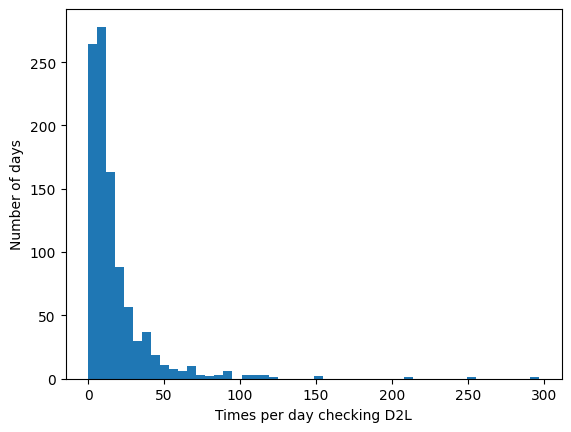

In [4]:
# generate some fake count data
# From Intro to Machine Learning with Python
X_org = rng.normal(size=(1000, 3))
X = rng.poisson(10 * np.exp(X_org))

plt.hist(X[:, 1], bins=50)

plt.xlabel("Times per day checking D2L")
plt.ylabel("Number of days")

plt.savefig("../../static/img/05-counts.png")

## Side comment on the central limit theorem
Sums of independent and identically distributed random variables converge to normal as number of samples increases.

As soon as one of those criteria are missing, you can't count on it anymore!

Text(0, 0.5, 'Number of days')

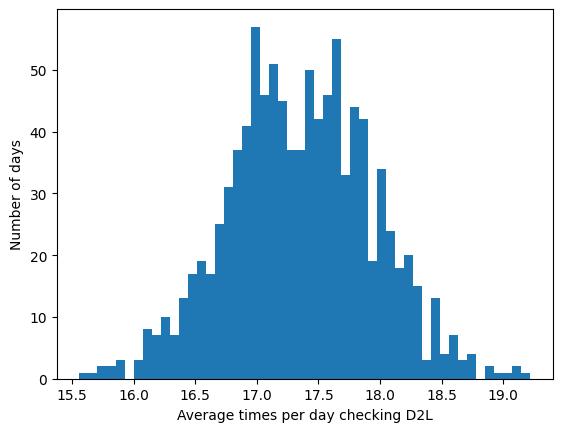

In [5]:
# CLT version
X_c = np.zeros(1000)
for i in range(len(X)):
    X_c[i] = rng.poisson(X[:, 1].mean(), size=50).mean()

plt.hist(X_c, bins=50)

plt.xlabel("Average times per day checking D2L")
plt.ylabel("Number of days")

## Back to the fake data
Create a fake (scalar) output using the "counts" data X (which is actually a matrix of 3 features) as input.

Note that the data generation doesn't actually use the count data directly, but instead is a linearly weighted combination of the normally distributed random samples that were used as parameters in the poisson distribution.

In [6]:
# Generate some more fake features and a fake X
# Repeated runs of the same cell results in different values unless we re-seed
rng = np.random.default_rng(seed=42)
w = rng.normal(size=3)
y = X_org.dot(w)

# the usual split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

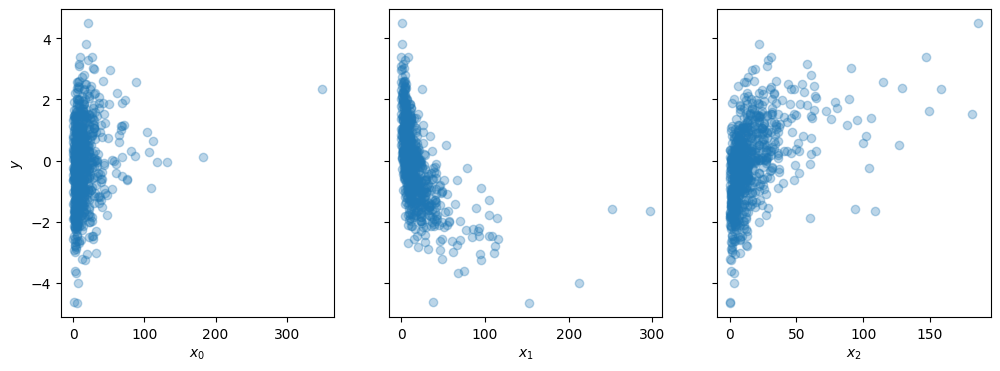

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axes[0].set_ylabel("$y$")
for i in range(3):
    axes[i].scatter(X_train[:, i], y_train, alpha=0.3)
    axes[i].set_xlabel(f"$x_{i}$")

In [8]:
# train a regression model on the raw data using stochastic gradient descent
model = SGDRegressor()
cross_val_score(model, X_train, y_train)

array([-1.96382775e+24, -2.94510142e+23, -3.87190276e+20, -5.49362175e+23,
       -1.13518130e+20])

In [9]:
# Add on the preprocessing pipeline
pipeline = make_pipeline(
    # FunctionTransformer(np.log1p), # log + 1
    StandardScaler(),
    model,
)

cross_val_score(pipeline, X_train, y_train)

array([0.56259745, 0.54778703, 0.56072741, 0.51452669, 0.59726864])

Text(2, -3, 'MSE = 0.73')

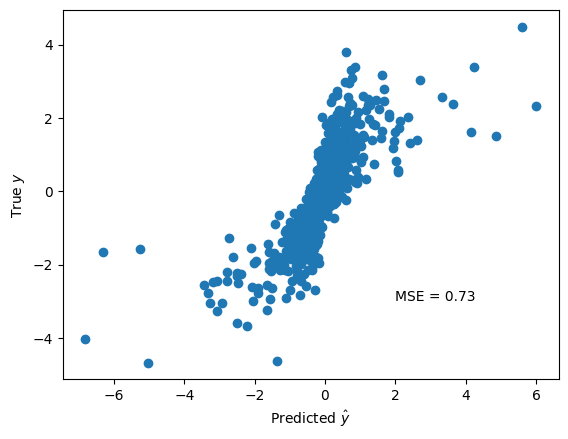

In [10]:
pipeline.fit(X_train, y_train)
y_est = pipeline.predict(X_train)
plt.scatter(y_est, y_train)
plt.xlabel(r"Predicted $\hat{y}$")
plt.ylabel("True $y$")
plt.text(2, -3, f"MSE = {np.mean((y_train - y_est)**2):.2f}")

## Mixed data types: Categorical and numeric


In [11]:
# Revisit the OKCupid data
df = pd.read_csv("../04_categorical/profiles_revised.csv")

In [12]:
# Target: job is "other" or "rather not say"
df["job"].value_counts()
df["mystery_job"] = df["job"].apply(lambda j: j in ["other", "rather not say"])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  offspring    24385 non-null  object 
 11  orientation  59946 non-null  object 
 12  pets         40025 non-null  object 
 13  religion     39720 non-null  object 
 14  sex          59946 non-null  object 
 15  sign         48890 non-null  object 
 16  smokes       54434 non-null  object 
 17  speaks       59896 non-null  object 
 18  status       59946 non-null  object 
 19  myst

In [159]:
# select features to use in the model
numeric_features = ["age", "height", "income"]
cat_features = ["drinks", "education", "sex"]

# For now, drop features with missing values
# We'll look at imputation later
df.dropna(subset=numeric_features + cat_features, inplace=True)

X = df[numeric_features + cat_features]
y = df["mystery_job"].astype(float)

# split!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=df["mystery_job"], random_state=12345
)

# count how many in each class
print(y_train.value_counts())
print(y_test.value_counts())

mystery_job
0.0    33341
1.0     5305
Name: count, dtype: int64
mystery_job
0.0    11114
1.0     1768
Name: count, dtype: int64


In [160]:
# Define the trickier encoders
drink_enc = OrdinalEncoder(
            categories=[
                [
                    "not at all",
                    "rarely",
                    "socially",
                    "often",
                    "very often",
                    "desperately",
                ]
            ],
            handle_unknown="use_encoded_value",
            unknown_value=-1,
        )

# This took a while mucking around to figure out the right magic between df/series
def split_edu(df):
    df["education"] = df["education"].str.split(" ")
    return df["education"]

edu_enc = make_pipeline(
        FunctionTransformer(split_edu, validate=False),
        FeatureHasher(n_features=16, input_type="string"),
    )


In [174]:
# Build the preprocessing pipeline
preprocessor = make_column_transformer(
    (PowerTransformer(method="yeo-johnson"), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), ["sex"]),
    (drink_enc, ["drinks"]),
    (edu_enc, ["education"]),
)#.set_output(transform="pandas")
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('powertransformer', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` 

In [ ]:
X_pro = preprocessor.fit_transform(X_train)

In [150]:
# only works with set_output(transform="pandas")
# pd.plotting.scatter_matrix(X_pro, figsize=(10, 10))

In [ ]:
# Now add on a model! Let's use a decision tree again
pipeline = make_pipeline(
    preprocessor,
    SGDClassifier(),
)

cross_val_score(pipeline, X_train, y_train)

array([0., 0., 0., 0., 0.])